In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

Dataset shape: (10479, 6)
               tot_cases     tot_deaths
state year                             
CA    2020  5.120195e+05    8732.120000
      2021  4.129310e+06   60943.865385
      2022  1.003382e+07   90568.807692
      2023  1.210051e+07  100381.052632
FL    2020  3.759536e+05    7641.900000
      2021  2.640017e+06   41945.288462
      2022  6.391604e+06   75745.442308
      2023  7.478803e+06   86270.315789
TX    2020  4.590364e+05    8635.800000
      2021  3.252734e+06   55156.865385
      2022  7.220451e+06   87727.750000
      2023  8.400530e+06   92985.052632
Agglomerative Clustering Silhouette Score: 0.3898519619146975


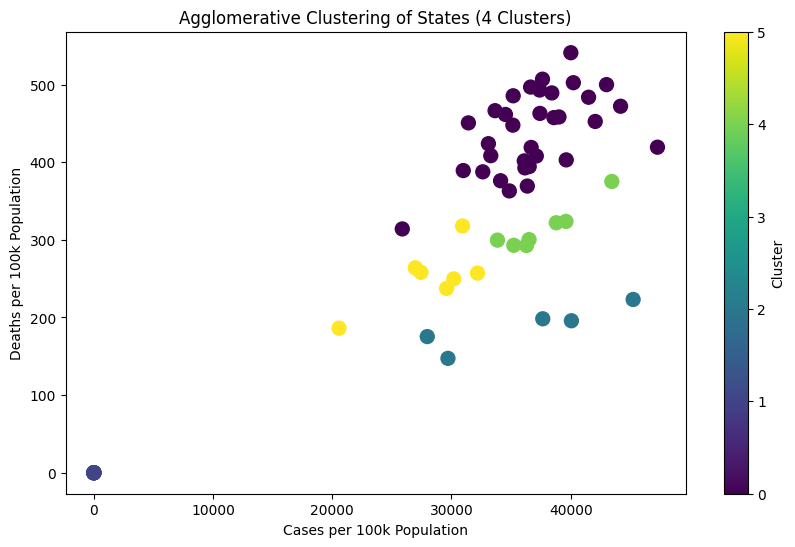

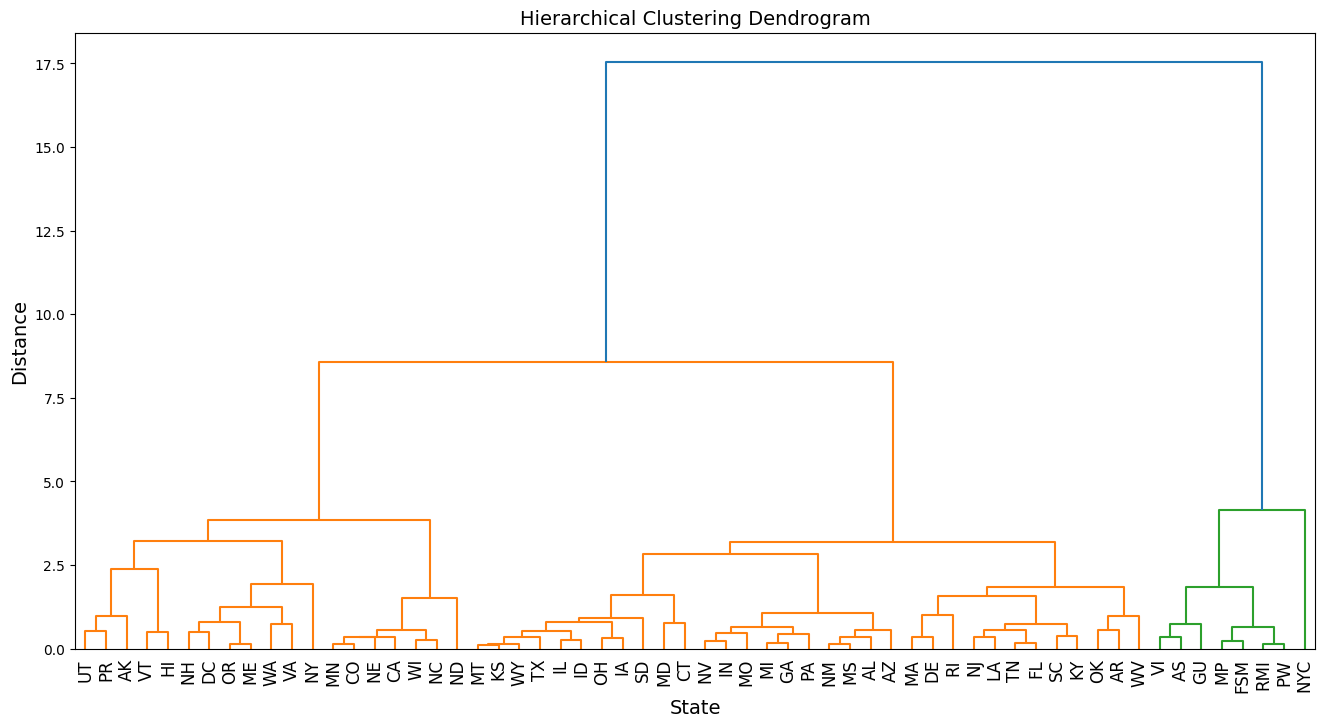

In [5]:
covid_data = pd.read_csv("death_sero.csv")
print("Dataset shape:", covid_data.shape)

sero_data = pd.read_csv("Nationwide_Commercial_Laboratory_Seroprevalence_Survey.csv")

# Filter death_sero data for CA, FL, TX 
filtered_df = covid_data[covid_data["state"].isin(["CA", "FL", "TX"])].copy()
filtered_df.head()

# Extract year from year_week 
filtered_df['year'] = filtered_df['year_week'].str.split('-').str[0].astype(int)

# Create averages by state and year
averages = filtered_df.groupby(['state', 'year'])[['tot_cases', 'tot_deaths']].mean()
print(averages)

state_aggregates = covid_data.groupby('state').agg({
    'tot_cases': 'max',
    'tot_deaths': 'max', 
    'n_samples': 'mean',
    'n_infected': 'mean'
}).reset_index()

state_aggregates = state_aggregates.fillna(0)

# Get population data from seroprevalence survey to merge with death_sero data
# Create a mapping of state populations
sero_pop = sero_data.groupby('Site')['Catchment population'].mean().reset_index()
sero_pop.rename(columns={'Site': 'state'}, inplace=True)

state_aggregates = state_aggregates.merge(sero_pop, on='state', how='left')
state_aggregates['Catchment population'] = state_aggregates['Catchment population'].fillna(0)

# Create per capita features
state_aggregates['cases_per_100k'] = np.where(
    state_aggregates['Catchment population'] > 0,
    (state_aggregates['tot_cases'] / state_aggregates['Catchment population']) * 100000,
    0
)

state_aggregates['deaths_per_100k'] = np.where(
    state_aggregates['Catchment population'] > 0,
    (state_aggregates['tot_deaths'] / state_aggregates['Catchment population']) * 100000,
    0
)


state_aggregates['case_fatality_rate'] = np.where(
    state_aggregates['tot_cases'] > 0, 
    state_aggregates['tot_deaths'] / state_aggregates['tot_cases'], 
    0
)

state_aggregates['infection_rate'] = np.where(
    state_aggregates['n_samples'] > 0,
    state_aggregates['n_infected'] / state_aggregates['n_samples'],
    0
)

covid_related = state_aggregates[[
    'cases_per_100k',
    'deaths_per_100k', 
    'case_fatality_rate',
    'infection_rate'
]]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(covid_related)

model = AgglomerativeClustering(n_clusters=6)
model.fit(scaled_features)

labels = model.labels_  

# Scatterplot
x = covid_related['cases_per_100k']
y = covid_related['deaths_per_100k']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=labels, cmap='viridis', s=100)

plt.xlabel('Cases per 100k Population')
plt.ylabel('Deaths per 100k Population')
plt.title('Agglomerative Clustering of States (4 Clusters)')
plt.colorbar(label='Cluster')

# dendrogram
linked = linkage(scaled_features, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linked,
           labels=state_aggregates['state'].values,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_font_size=12)

plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.ylabel('Distance', fontsize=14)
plt.xticks(rotation=90)


score = silhouette_score(scaled_features, labels)
print("Agglomerative Clustering Silhouette Score:", score)

In [9]:
sorted_state_aggregates = state_aggregates.sort_values(by='deaths_per_100k')
sorted_state_aggregates

,state,tot_cases,tot_deaths,n_samples,n_infected,Catchment population,cases_per_100k,deaths_per_100k,case_fatality_rate,infection_rate
3,AS,8331.0,34.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.004081,0.000000
11,FSM,26453.0,64.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.002419,0.000000
13,GU,61642.0,415.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.006732,0.000000
28,MP,13886.0,44.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.003169,0.000000
54,VI,24994.0,131.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.005241,0.000000
45,PW,6000.0,9.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.001500,0.000000
47,RMI,16081.0,17.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.001057,0.000000
39,NYC,3266726.0,45181.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.013831,0.000000
14,HI,374264.0,1856.0,25315.177381,1276.821429,1.259981e+06,29703.929877,147.303758,0.004959,0.050437
55,VT,154243.0,967.0,16513.355333,797.555556,5.514806e+05,27968.891016,175.346159,0.006269,0.048298


In [7]:
# Create a DataFrame with state names and cluster labels
state_clusters = pd.DataFrame({
    'state': state_aggregates['state'],
    'cluster': labels
})

# Assign colors to clusters
cluster_colors = plt.cm.viridis(np.linspace(0, 1, len(state_clusters['cluster'].unique())))
state_clusters['color'] = state_clusters['cluster'].map(
    {cluster: color for cluster, color in enumerate(cluster_colors)}
)
state_clusters_sorted = state_clusters.sort_values(by='cluster')
# Display the table
print(state_clusters_sorted)

   state  cluster                                color
1     AL        0  [0.267004, 0.004874, 0.329415, 1.0]
2     AR        0  [0.267004, 0.004874, 0.329415, 1.0]
7     CT        0  [0.267004, 0.004874, 0.329415, 1.0]
4     AZ        0  [0.267004, 0.004874, 0.329415, 1.0]
12    GA        0  [0.267004, 0.004874, 0.329415, 1.0]
15    IA        0  [0.267004, 0.004874, 0.329415, 1.0]
10    FL        0  [0.267004, 0.004874, 0.329415, 1.0]
9     DE        0  [0.267004, 0.004874, 0.329415, 1.0]
23    MD        0  [0.267004, 0.004874, 0.329415, 1.0]
22    MA        0  [0.267004, 0.004874, 0.329415, 1.0]
21    LA        0  [0.267004, 0.004874, 0.329415, 1.0]
20    KY        0  [0.267004, 0.004874, 0.329415, 1.0]
19    KS        0  [0.267004, 0.004874, 0.329415, 1.0]
18    IN        0  [0.267004, 0.004874, 0.329415, 1.0]
17    IL        0  [0.267004, 0.004874, 0.329415, 1.0]
16    ID        0  [0.267004, 0.004874, 0.329415, 1.0]
25    MI        0  [0.267004, 0.004874, 0.329415, 1.0]
27    MO  